In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import sys 
sys.path.append('../../src')
import glob
from spaceoracle.gene_factory import GeneFactory
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography

2025-05-18 14:25:26.986721: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [3]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')
# adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13.h5ad')
adata

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [5]:
gf = GeneFactory(
    adata=adata, 
    models_dir='/ix/djishnu/shared/djishnu_kor11/lasso_runs/mouse_kidney_13',
    annot='cell_type_int',
    radius=200,
    contact_distance=30, 
)

# assert len(gf.queue.remaining_genes) == 0

In [6]:
adata.obs[['cell_type', 'ct3']].value_counts()

cell_type            ct3                                   
Myeloid              Mac_2                                     1852
                     Mac_0                                     1385
Endothelial          Endothelial_Capilary                      1139
Myeloid              Mac_3_TGFB3+                              1034
B                    B                                          327
Endothelial          Endothelial_Anti-Apoptosis_0               266
Myeloid              Mac_4                                      231
                     cDC_Xcr1+                                  166
T                    Memory_T                                   163
Endothelial          Endothelial_Anti-Apoptosis_2               152
Myeloid              Mac_1_CellCycle+_1                         133
Endothelial          Endothelial_DVR                            120
Myeloid              cDC2_1                                     109
B                    B_Memory                           

### Check TF target

In [20]:
from spaceoracle.tools.network import RegulatoryFactory

base_dir = '/ix/djishnu/shared/djishnu_kor11/'
co_grn = RegulatoryFactory(
    colinks_path=base_dir + 'training_data_2025/mouse_kidney_13_colinks.pkl',
    annot='cell_type_int'
)

big_links = pd.concat(
    [links.assign(cell_type=label) for label, links in co_grn.links.items()],
    axis=0
)
big_links = big_links.query('p < 0.05')
big_links.sort_values('coef_mean', ascending=False, inplace=True)

In [ ]:
big_links.query('target == "Myh10" and cell_type == "Epithelial"')

In [ ]:
big_links.query('source == "Elf5" and cell_type == "Epithelial"')

In [ ]:
big_links.query('source == "Ehf" and cell_type == "Epithelial"')

In [ ]:
cells = adata[adata.obs['cell_type'].isin(['Epithelial'])].to_df(layer='imputed_count')
# cells = cells[cells['Pax8'] > 0]
plt.figure(figsize=(5, 2))
plt.hist(cells['Myh10'], label='Myh10', alpha=0.5)
plt.hist(cells['Pax8'], label='Pax8', alpha=0.5)
plt.hist(cells['Elf5'], label='Elf5', alpha=0.5)
plt.hist(cells['Ehf'], label='Ehf', alpha=0.5)

plt.legend()
plt.show()

In [ ]:
cells['Elf5'].mean(), cells['Ehf'].mean()

### Perturb

In [6]:
import warnings
warnings.filterwarnings('ignore', message='Pandas doesn\'t allow columns to be created via a new attribute name')

In [7]:
# gex = 2
# target = 'Jag1'
# gex_df = gf.perturb(
#     target=target,
#     n_propagation=4,
#     gene_expr=gex,
#     save_layer=False,
#     cells=None,
#     delta_dir=None
# )

# gex_df.to_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_kidney_13/{target}_4n_{gex}x.parquet')

In [8]:
target = 'Mif'
gex = 0
gex_df = pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_kidney_13/{target}_4n_{gex}x.parquet')
adata.layers['Mif'] = gex_df.loc[adata.obs.index, adata.var.index].values

In [9]:
colors = ["#9ac54f",
"#8146b8",
"#87b997",
"#c45183",
"#4c3c3a",
"#c46f41",
"#8d93c1"]

color_dict = {
    ct: color for ct, color in zip(adata.obs['cell_type'].unique(), colors)
}

In [10]:
# target_gene = target
chart = Cartography(adata, color_dict)

### Quiver plots

In [7]:
# banksy_df = pd.read_csv('banksy_mouse_kidney_13.csv', index_col=0)
# adata.obs['banksy_cluster'] = banksy_df['banksy_cluster']
# adata.obsm['X_umap'] = banksy_df.reindex(adata.obs.index, axis=0)[['x_umap', 'y_umap']].values


In [10]:
banksy_df = pd.read_csv('banksy_mouse_kidney_13.csv', index_col = 0)
adata.obs['banksy_cluster'] = banksy_df['banksy_cluster']

adata.obsm['X_banksy'] = banksy_df[['x_umap','y_umap']].values

In [19]:
chart = Cartography(adata, color_dict)

In [ ]:
sample = 'mouse_kidney_13'
cluster_label = 'cell_type'

kotarget = 'Mif'
ax = chart.plot_umap_quiver(
    # perturbed_df=gex_df,
    perturb_target=kotarget,
    grid_scale=1,
    vector_scale=0.8,
    figsize=(5, 5), 
    hue=cluster_label,
    alpha=0.5,
    scatter_size=10,
    betadata_path=f'/ix/djishnu/shared/djishnu_kor11/genome_screens/{sample}',
    legend_on_loc=False,
)
ax.legend(
    bbox_to_anchor=(0.5, 0.0),
    loc='upper center', ncol=3, 
    frameon=False, markerscale=1.5,
    fontsize=6
)


# Add cluster labels on top of points
for cluster in adata.obs[cluster_label].unique():
    mask = adata.obs[cluster_label] == cluster
    x = adata.obsm['X_umap'][mask, 0].mean()
    y = adata.obsm['X_umap'][mask, 1].mean()
    ax.text(x, y, str(cluster),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=8,
            bbox=dict(facecolor='gray', alpha=0.2, edgecolor='none'))

plt.title(f'{sample} {kotarget} KO')
plt.show()

In [31]:
color_dict

{'Myeloid': '#9ac54f',
 'NK': '#8146b8',
 'T': '#87b997',
 'B': '#c45183',
 'Endothelial': '#4c3c3a',
 'Epithelial': '#c46f41',
 'Mesenchymal_Stromal': '#8d93c1'}

In [11]:
adata_ = adata[adata.obs['ct3'].str.contains('Mac')]


In [12]:
colors =[
    "#626fc5",
    "#b6b434",
    "#a058c7",
    "#5bb84d",
    "#d050a6",
    "#38824d",
    "#d53e67",
    "#55bf9e",
    "#d15135",
    "#4fa7d6",
    "#d99a4a",
    "#c38ecf",
    "#97b05f",
    "#9e4b70",
    "#72752b",
    "#dc7c7f",
    "#a26334"
]
# # color_dict = {i: color for i, color in zip(adata_.obs['ct3'].unique(), colors)}
# color_dict = {i: color for i, color in zip(adata_.obs['banksy_cluster'].unique(), colors)}

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/scanpy/tools/_leiden.py:197: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


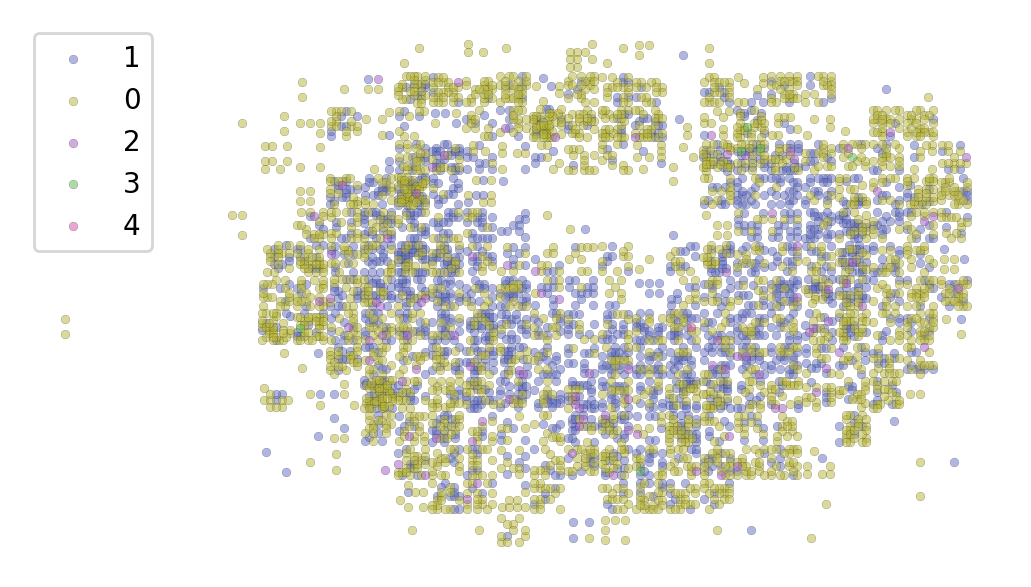

In [13]:
sc.tl.leiden(adata_, key_added='leiden', resolution=0.15)

color_dict = {i: color for i, color in zip(adata_.obs['leiden'].unique(), colors)}

for ct in adata_.obs['leiden'].unique():
    mask = adata_.obs['leiden'] == ct
    plt.scatter(
        adata_.obsm['spatial'][mask, 0], adata_.obsm['spatial'][mask, 1],
        c=color_dict[ct], s=10, alpha=0.5, label=ct,
        edgecolor='black', linewidth=0.1
    )
plt.legend()
plt.gca().set_axis_off()
plt.gca().set_aspect('equal')

plt.show()


In [14]:
adata_.obs['leiden'].value_counts()

leiden
0    2571
1    1989
2      96
3       6
4       1
Name: count, dtype: int64

In [15]:
color_dict = {'1': '#626fc5',
 '0': '#b6b434',
 '2': '#a058c7',
 '3': '#5bb84d',
 '4': '#d050a6'}

In [16]:
marker_dict = {
    'osmogenes': ['Aqp2', 'Aqp4', 'Cryab', 'Elf5', 'Mal', 'Muc1',
        'Pax2', 'Sgk1', 'Slc14a2', 'Slc5a3'],
    'Mac': ['Itgam', 'Adgre1'],
    'M1-like': ["Tnf", 'Ccl2', 'Cd86', 'Cd80', 'Il1r1', 'Il1r2'],
    'M2-like': ['Arg1', 'Mrc1', 'Msr1', 'Fcer2a']
}

# marker_dict = {k: [x for x in v if x in adata.var_names] for k,v in marker_dict.items()}
# sc.pl.dotplot(
#     adata_,
#     marker_dict,
#     # layer='imputed_count', 
#     layer='normalized_count',  
#     # groupby='banksy_cluster',
#     # groupby='ct3',
#     groupby='leiden', 
#     dendrogram=False,
#     standard_scale='var',
#     figsize=(10, 4), 
#     # title='Macrophage Markers in mouse_kidney_13',
# )


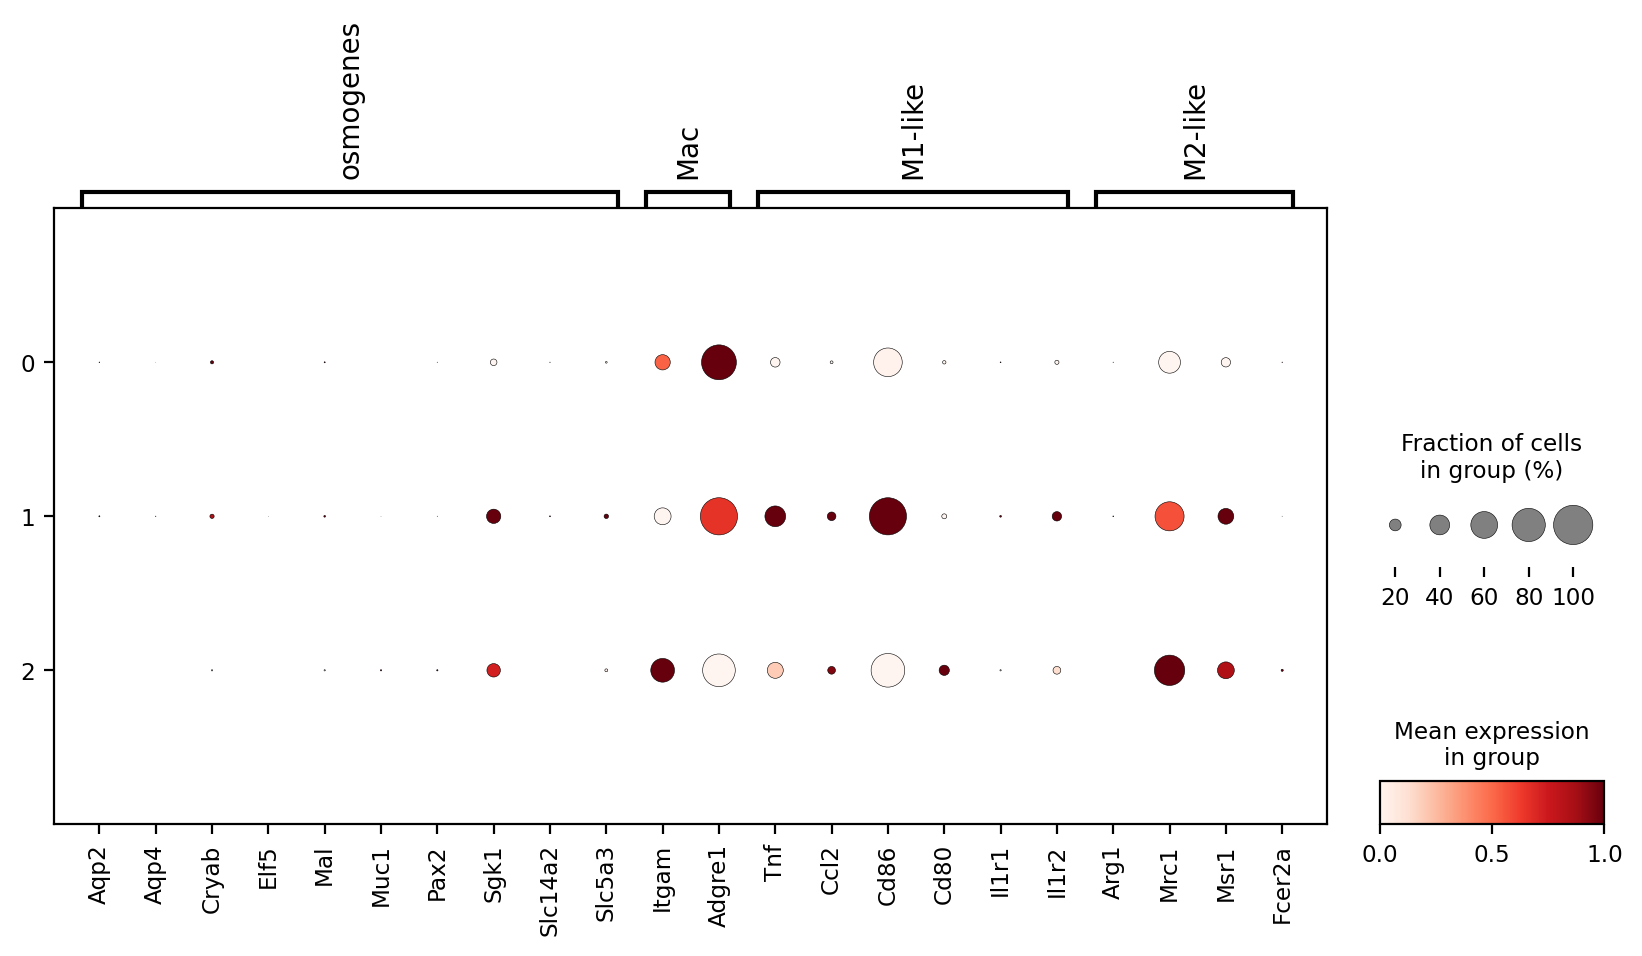

In [17]:
adata_ = adata_[adata_.obs['leiden'].isin(['1', '0', '2'])]

sc.pl.dotplot(
    adata_,
    marker_dict,
    # layer='imputed_count', 
    layer='normalized_count',  
    # groupby='banksy_cluster',
    # groupby='ct3',
    groupby='leiden', 
    dendrogram=False,
    standard_scale='var',
    figsize=(10, 4), 
    # title='Macrophage Markers in mouse_kidney_13',
)


In [18]:
chart_ = Cartography(adata=adata_, color_dict=color_dict)

In [19]:
# sample = 'mouse_kidney_13'

# kotarget = 'Mif'
# ax = chart_.plot_umap_quiver(
#     perturb_target=kotarget,
#     grid_scale=1,
#     vector_scale=1,
#     figsize=(5, 5), 
#     hue='leiden',
#     alpha=0.5,
#     scatter_size=10,
#     betadata_path=f'/ix/djishnu/shared/djishnu_kor11/genome_screens/{sample}', 
#     legend_on_loc=False,
# )
# # Add legend at bottom
# ax.legend(
#     bbox_to_anchor=(0.5, 0.0),
#     loc='upper center', ncol=3, 
#     frameon=False, markerscale=1.5,
#     fontsize=6
# )

# # plt.title(f'{sample} {kotarget} Perturbation (Macs only)')
# plt.show()

In [20]:
delta_X = (chart_.adata.to_df(layer='Mif') - chart_.unperturbed_expression).values
gene_mtx = chart_.unperturbed_expression.values

corr = chart_.compute_perturbation_corr(gene_mtx, delta_X)
corr.shape

(4656, 4656)

In [21]:
null_corr = chart_.compute_perturbation_corr(gene_mtx, delta_X * 0)

In [20]:
# source_ct = '0'
# transition_df = chart_.compute_transitions(corr, source_ct=source_ct, annot='leiden')
# chart_.assess_transitions(
#     transition_df, adata_.obs['leiden'], source_ct, 'leiden')

Source Cells: 0             min      mean       max
Transition Target                                  
0                  2.060491e-04  0.000384  0.000389
2                  1.496400e-07  0.000013  0.002588
1                  1.838228e-07  0.000006  0.000225

In [45]:
# print(f'source{source_ct} transitions')
# fates = chart_.get_cellfate(transition_df, 
#                     allowed_fates=adata_.obs['leiden'].unique(), thresh=0.0002, annot='leiden')

source0 transitions
Counter({'0': 2686, '2': 15}) 0.00036905659043550543


In [46]:
# source_ct = '1'

# transition_df = chart_.compute_transitions(corr, source_ct=source_ct, annot='leiden')
# chart_.assess_transitions(
#     transition_df, adata_.obs['leiden'], source_ct, 'leiden')

Source Cells: 1             min      mean       max
Transition Target                                  
1                  1.897776e-06  0.000232  0.000468
0                  4.760153e-05  0.000209  0.000369
2                  4.576541e-07  0.000032  0.002771

In [47]:
# print(f'source{source_ct} transitions')
# fates = chart_.get_cellfate(transition_df, 
#                     allowed_fates=adata_.obs['leiden'].unique(), thresh=0.0002, annot='leiden')

source1 transitions
Counter({'1': 1036, '0': 813, '2': 9}) 0.00037194698477318976


In [48]:
# from numba import jit

# # Cannibalized from CellOracle
# @jit(nopython=True)
# def permute_rows_nsign(A: np.ndarray) -> None:
#     """Permute in place the entries and randomly switch the sign for each row of a matrix independently.
#     """
#     plmi = np.array([+1, -1])
#     for i in range(A.shape[0]):
#         np.random.shuffle(A[i, :])
#         A[i, :] = A[i, :] * np.random.choice(plmi, size=A.shape[1])


In [ ]:
# rand_corr = corr.copy()
# permute_rows_nsign(rand_corr)


# source_ct = '0'
# print(f'randomly permuted source {source_ct} transitions')
# transition_df = chart_.compute_transitions(rand_corr, source_ct=source_ct, annot='leiden')
# fates = chart_.get_cellfate(transition_df, 
#                     allowed_fates=adata_.obs['leiden'].unique(), thresh=0.0002, annot='leiden')
# print('\n')
# source_ct = '1'
# print(f'randomly permuted source{source_ct} transitions')
# transition_df = chart_.compute_transitions(rand_corr, source_ct=source_ct, annot='leiden')
# fates = chart_.get_cellfate(transition_df, 
#                     allowed_fates=adata_.obs['leiden'].unique(), thresh=0.0002, annot='leiden')


randomly permuted source 0 transitions
Counter({'0': 1182, '1': 947, '2': 572}) 0.00036982457324266307


randomly permuted source1 transitions


### Make matching figures

In [22]:
import alphashape
from matplotlib.legend_handler import HandlerTuple
import matplotlib
import seaborn as sns 
from shapely.geometry import Point

In [23]:
adata = adata_
chart = chart_

In [24]:
xy = pd.DataFrame(adata.obsm['spatial'], columns=['x', 'y'], index=adata.obs.index)
adata.obs['x'] = adata.obsm['spatial'][:, 0]
adata.obs['y'] = adata.obsm['spatial'][:, 1]

/tmp/ipykernel_52887/4204389215.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['x'] = adata.obsm['spatial'][:, 0]


In [25]:
genes = ['Aqp2', 'Aqp4', 'Cryab', 'Elf5', 'Mal', 'Muc1',
        'Pax2', 'Sgk1', 'Slc14a2', 'Slc5a3',
        "Tnf", 'Ccl2', 'Cd86', 'Cd80', 'Il1r1', 'Il1r2',
        'Arg1', 'Mrc1', 'Msr1', 'Fcer2a']

df = adata[:,genes].to_df(layer='normalized_count')
df['leiden'] = adata.obs['leiden'].astype('category')
df.to_csv('figures/dfs/mouse_kidney_13_leiden_markers.csv')

In [32]:
try:
    del chart.adata.obs['transition']
except:
    pass

In [33]:
# transitions = chart.get_cellfate(
#     transition_df, allowed_fates=['0', '1', '2'], thresh=0.0002, annot='leiden')
# adata.obs['transition'] = transitions

chart.get_transition_annot(
    corr, 
    allowed_fates=['0', '1', '2'], 
    thresh=0, 
    annot='leiden'
)

source ct 1 Counter({'1': 1027, '0': 957, '2': 5}) 0.0003523275543776481 0.0
source ct 0 Counter({'0': 2563, '2': 8}) 0.00038648989257790927 0.0
source ct 2 Counter({'2': 51, '0': 45}) 0.002605530574951097 0.0


In [34]:
source_cells = adata.obs.index

In [35]:
ct_points_wt, ct_points_ko = chart.make_celltype_dict(annot='leiden')

In [36]:
alpha_shape_0 = alphashape.alphashape(ct_points_wt['0'], alpha=0.05)
alpha_shape_1 = alphashape.alphashape(ct_points_wt['1'], alpha=0.06)
alpha_shape_2 = alphashape.alphashape(ct_points_wt['2'], alpha=0.06)

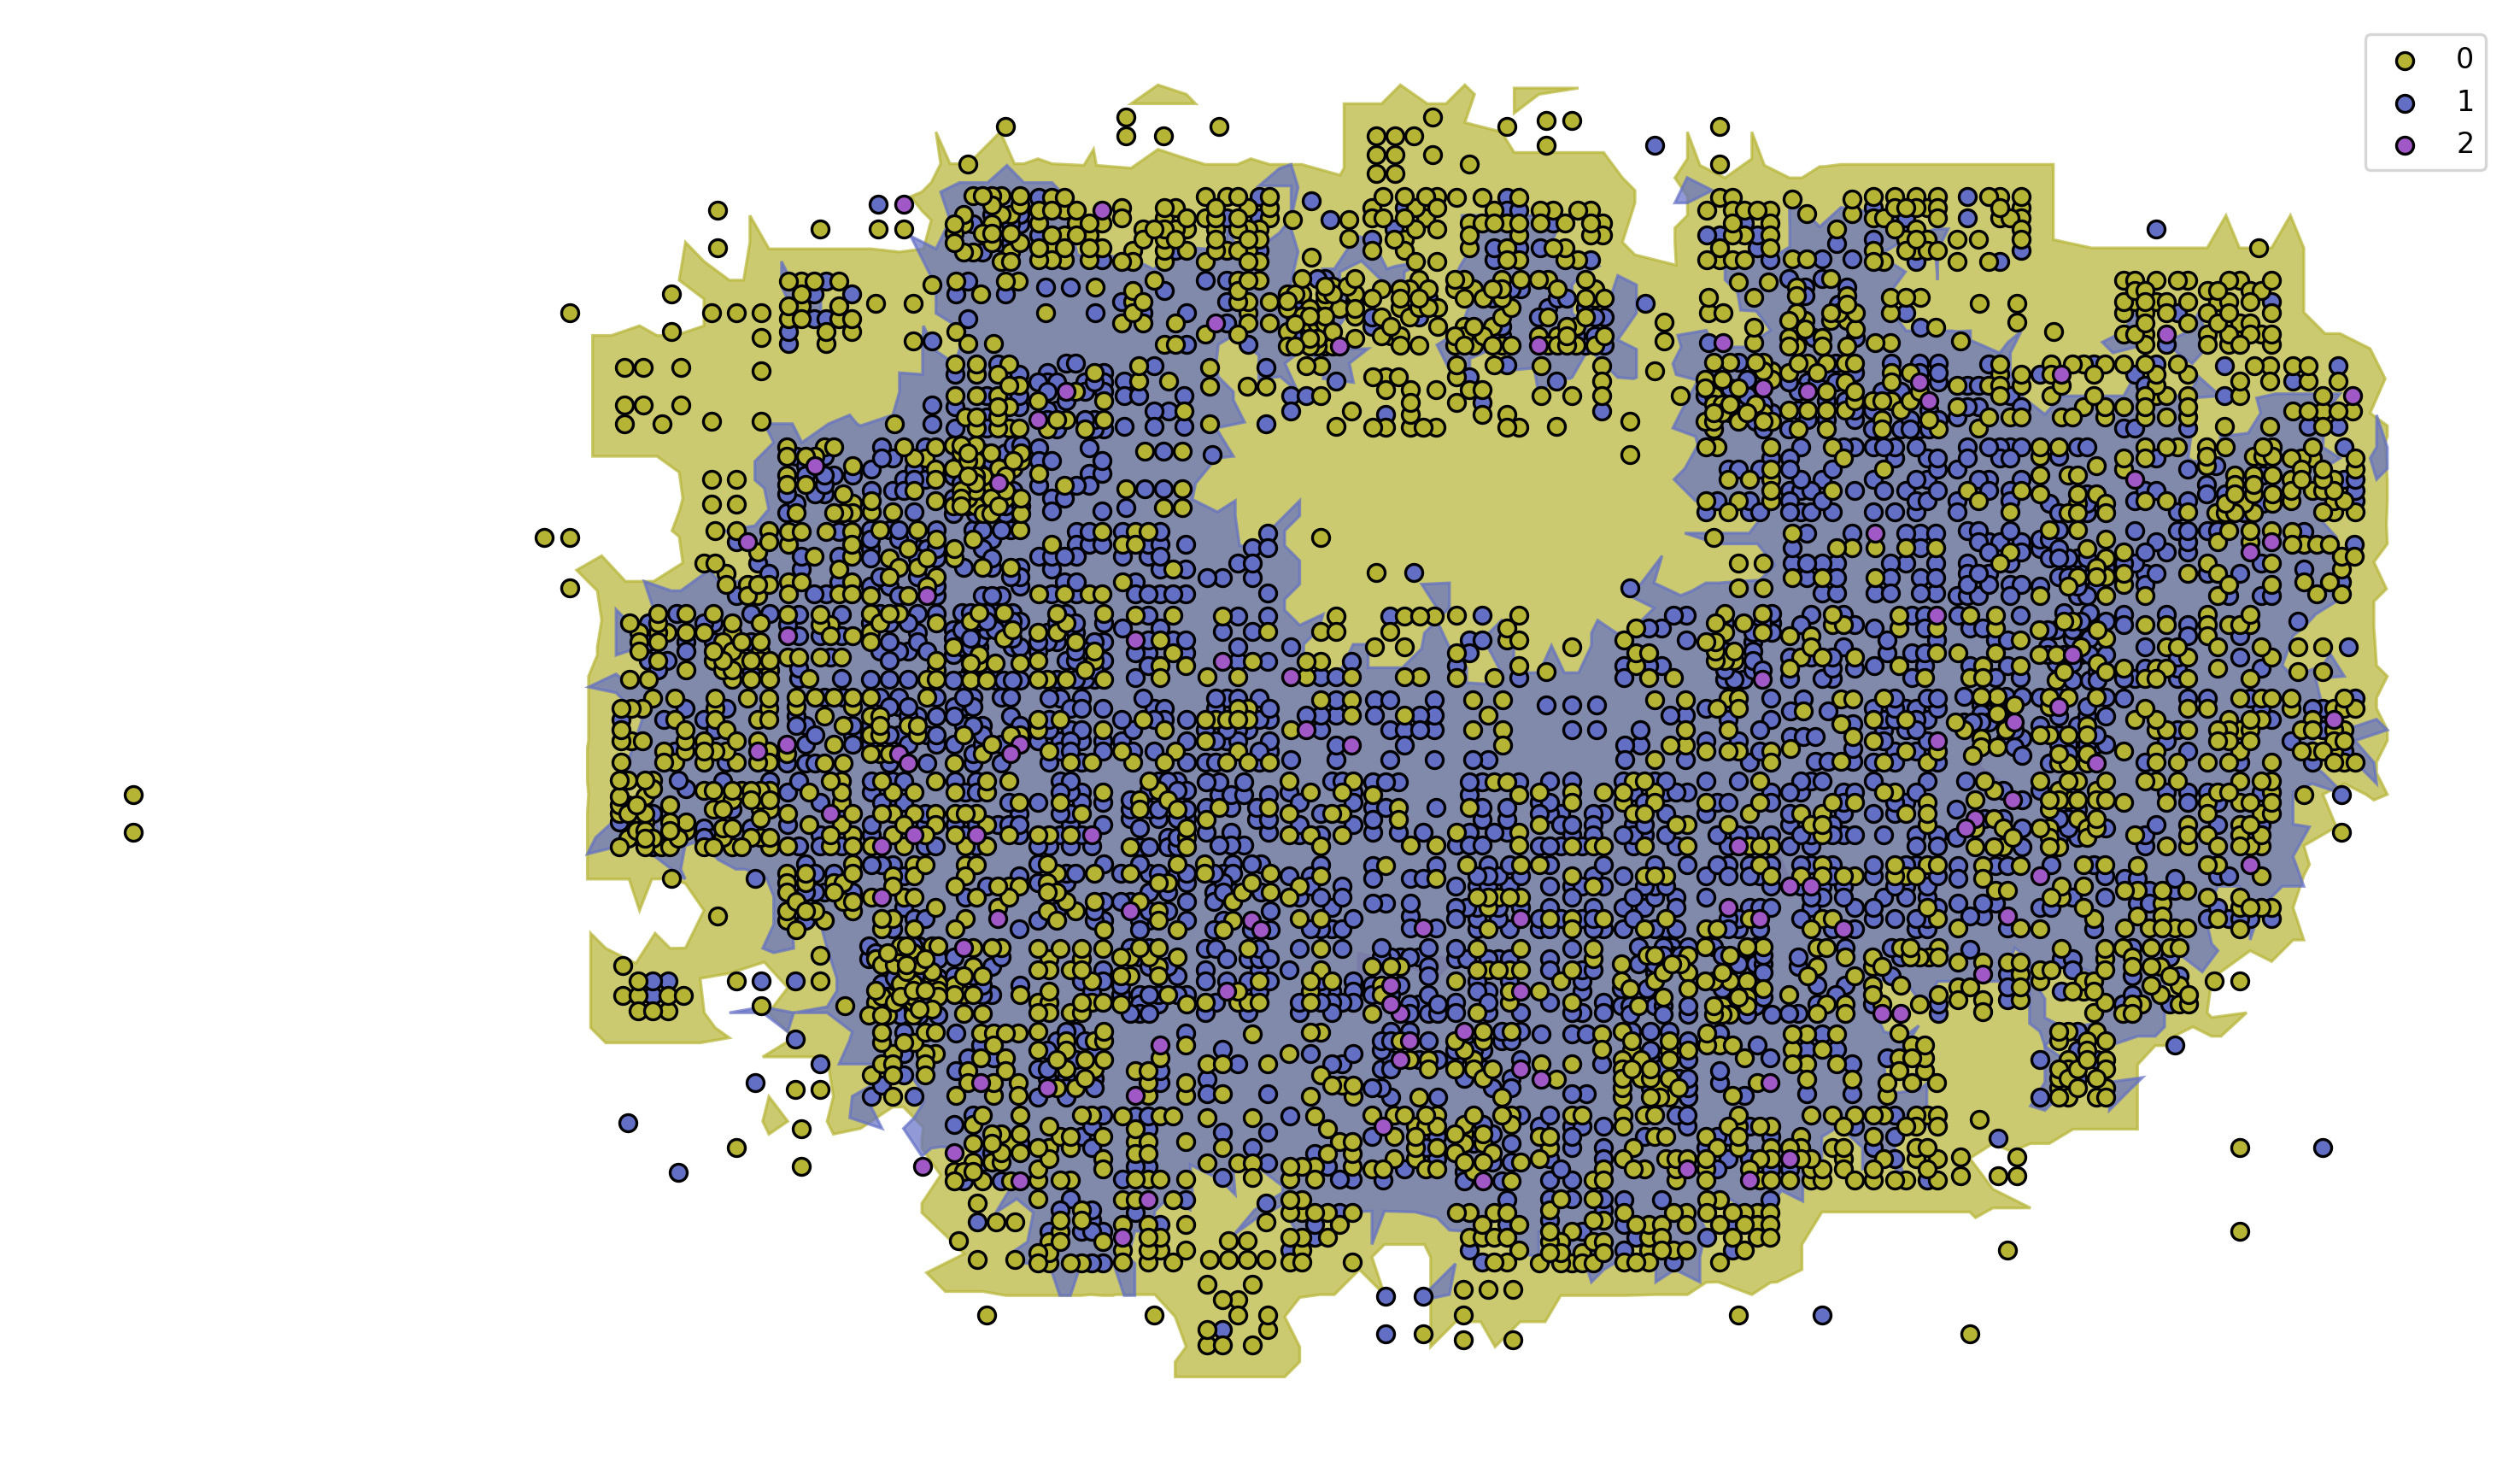

In [37]:
fig, ax = plt.subplots(figsize=(20, 9), dpi=120)

scatter = sns.scatterplot(
    data = adata.obs,
    x='x', y='y',
    # hue='banksy_celltypes', 
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    # palette=color_dict,
    ax=ax,
)

zone_alpha = 0.7
area_thresh = 400

for geom in alpha_shape_2.geoms:
    if geom.area > area_thresh:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['2'], alpha=zone_alpha)


for geom in alpha_shape_0.geoms:
    if geom.area > area_thresh:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['0'], alpha=zone_alpha)
    

for geom in alpha_shape_1.geoms:
    if geom.area > area_thresh:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['1'], alpha=zone_alpha)
        

for ct in adata.obs['leiden'].unique():
    ax.scatter(
        adata[adata.obs['leiden'] == ct].obsm['spatial'][:, 0],
        adata[adata.obs['leiden'] == ct].obsm['spatial'][:, 1],
        c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1, label=ct
    )

handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: int(x[1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
ax.legend(sorted_handles, sorted_labels)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
# ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
# ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)

plt.savefig(f'figures/mouse_kidney_13_MifKO_preKO.svg', format='svg')

In [38]:
alpha_shape_0 = alphashape.alphashape(ct_points_ko['0'], alpha=0.05)
alpha_shape_1 = alphashape.alphashape(ct_points_ko['1'], alpha=0.06)
alpha_shape_2 = alphashape.alphashape(ct_points_ko['2'], alpha=0.06)

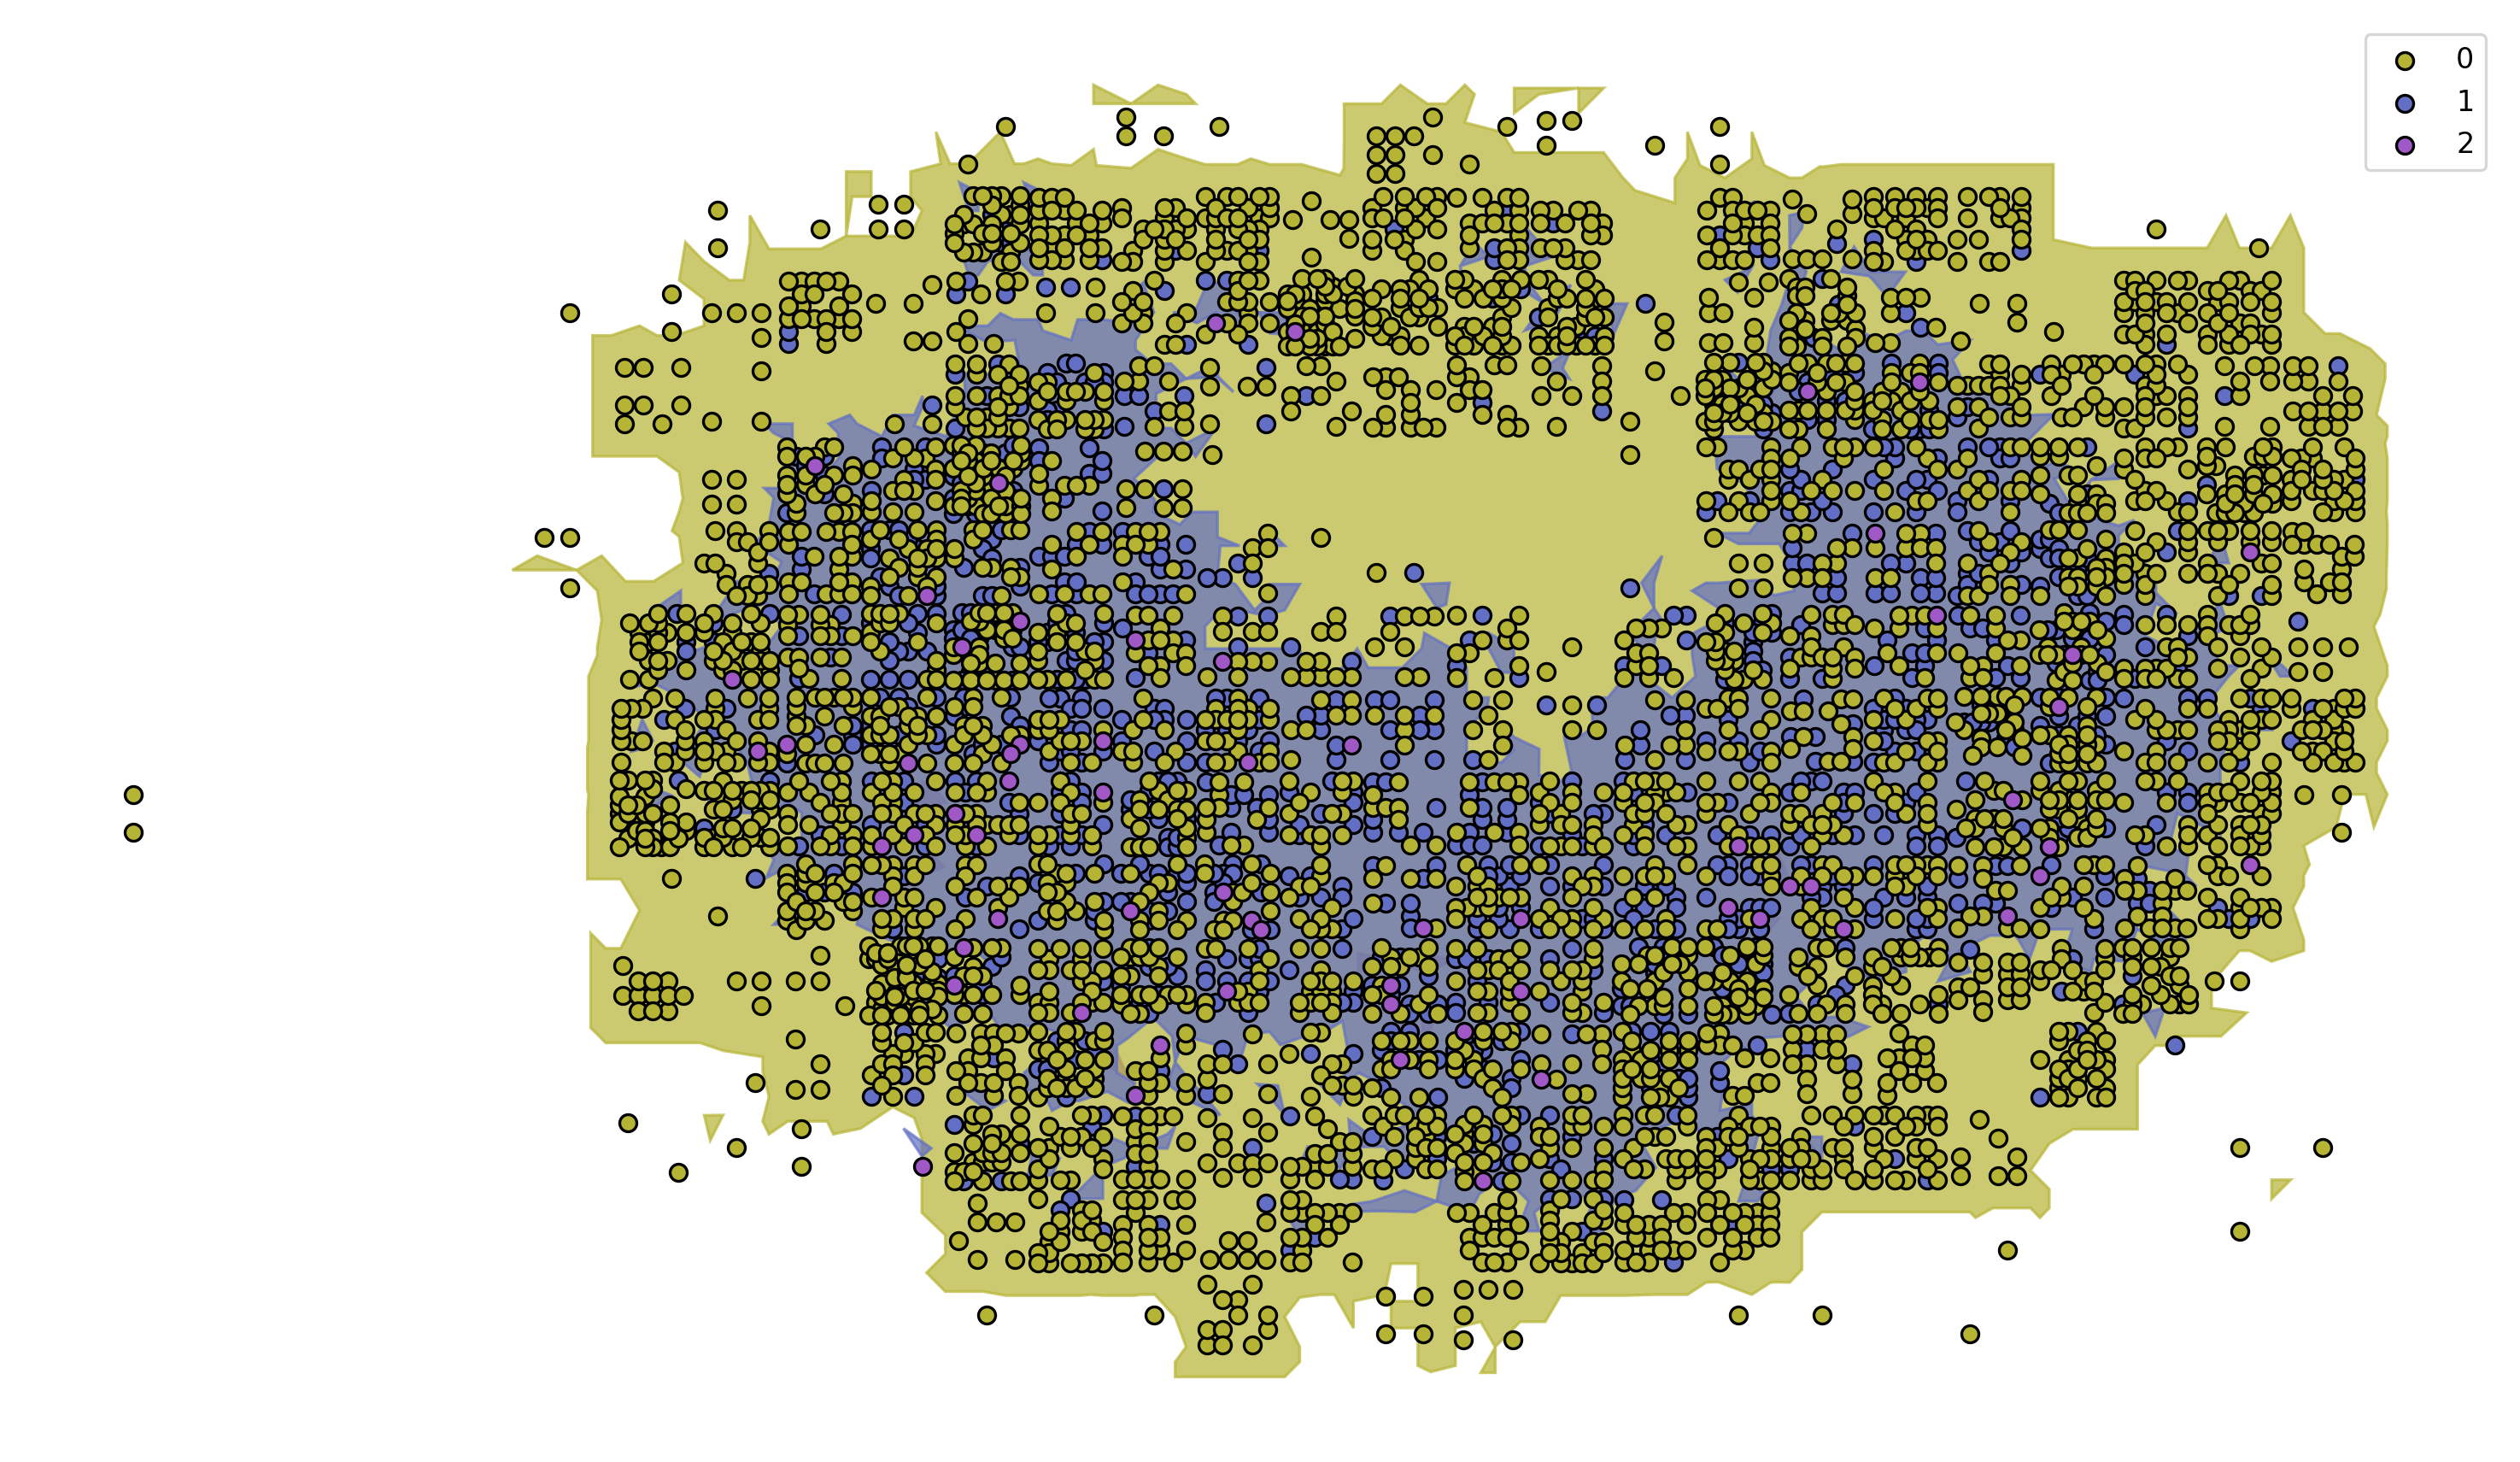

In [39]:
fig, ax = plt.subplots(figsize=(20, 9), dpi=120)

scatter = sns.scatterplot(
    data = adata.obs,
    x='x', y='y',
    # hue='banksy_celltypes', 
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    # palette=color_dict,
    ax=ax,
)

zone_alpha = 0.7
area_thresh = 150

for geom in alpha_shape_2.geoms:
    if geom.area > area_thresh:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['2'], alpha=zone_alpha)


for geom in alpha_shape_0.geoms:
    if geom.area > area_thresh:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['0'], alpha=zone_alpha)

for geom in alpha_shape_1.geoms:
    if geom.area > area_thresh:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['1'], alpha=zone_alpha)

for ct in adata.obs['transition'].unique():
    ax.scatter(
        adata[adata.obs['transition'] == ct].obsm['spatial'][:, 0],
        adata[adata.obs['transition'] == ct].obsm['spatial'][:, 1],
        c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1,
        label=ct
    )

handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: int(x[1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
ax.legend(sorted_handles, sorted_labels)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
# ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
# ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)

plt.savefig(f'figures/mouse_kidney_13_MifKO_postKO.svg', format='svg')

In [40]:
df = adata.obs[['leiden', 'transition']].copy()
df['leiden'] = pd.Categorical(df['leiden'], ordered=True, categories=sorted(df['leiden'].unique(), key=lambda x: int(x)))
counts = df.groupby(['leiden', 'transition']).size().unstack(fill_value=0)


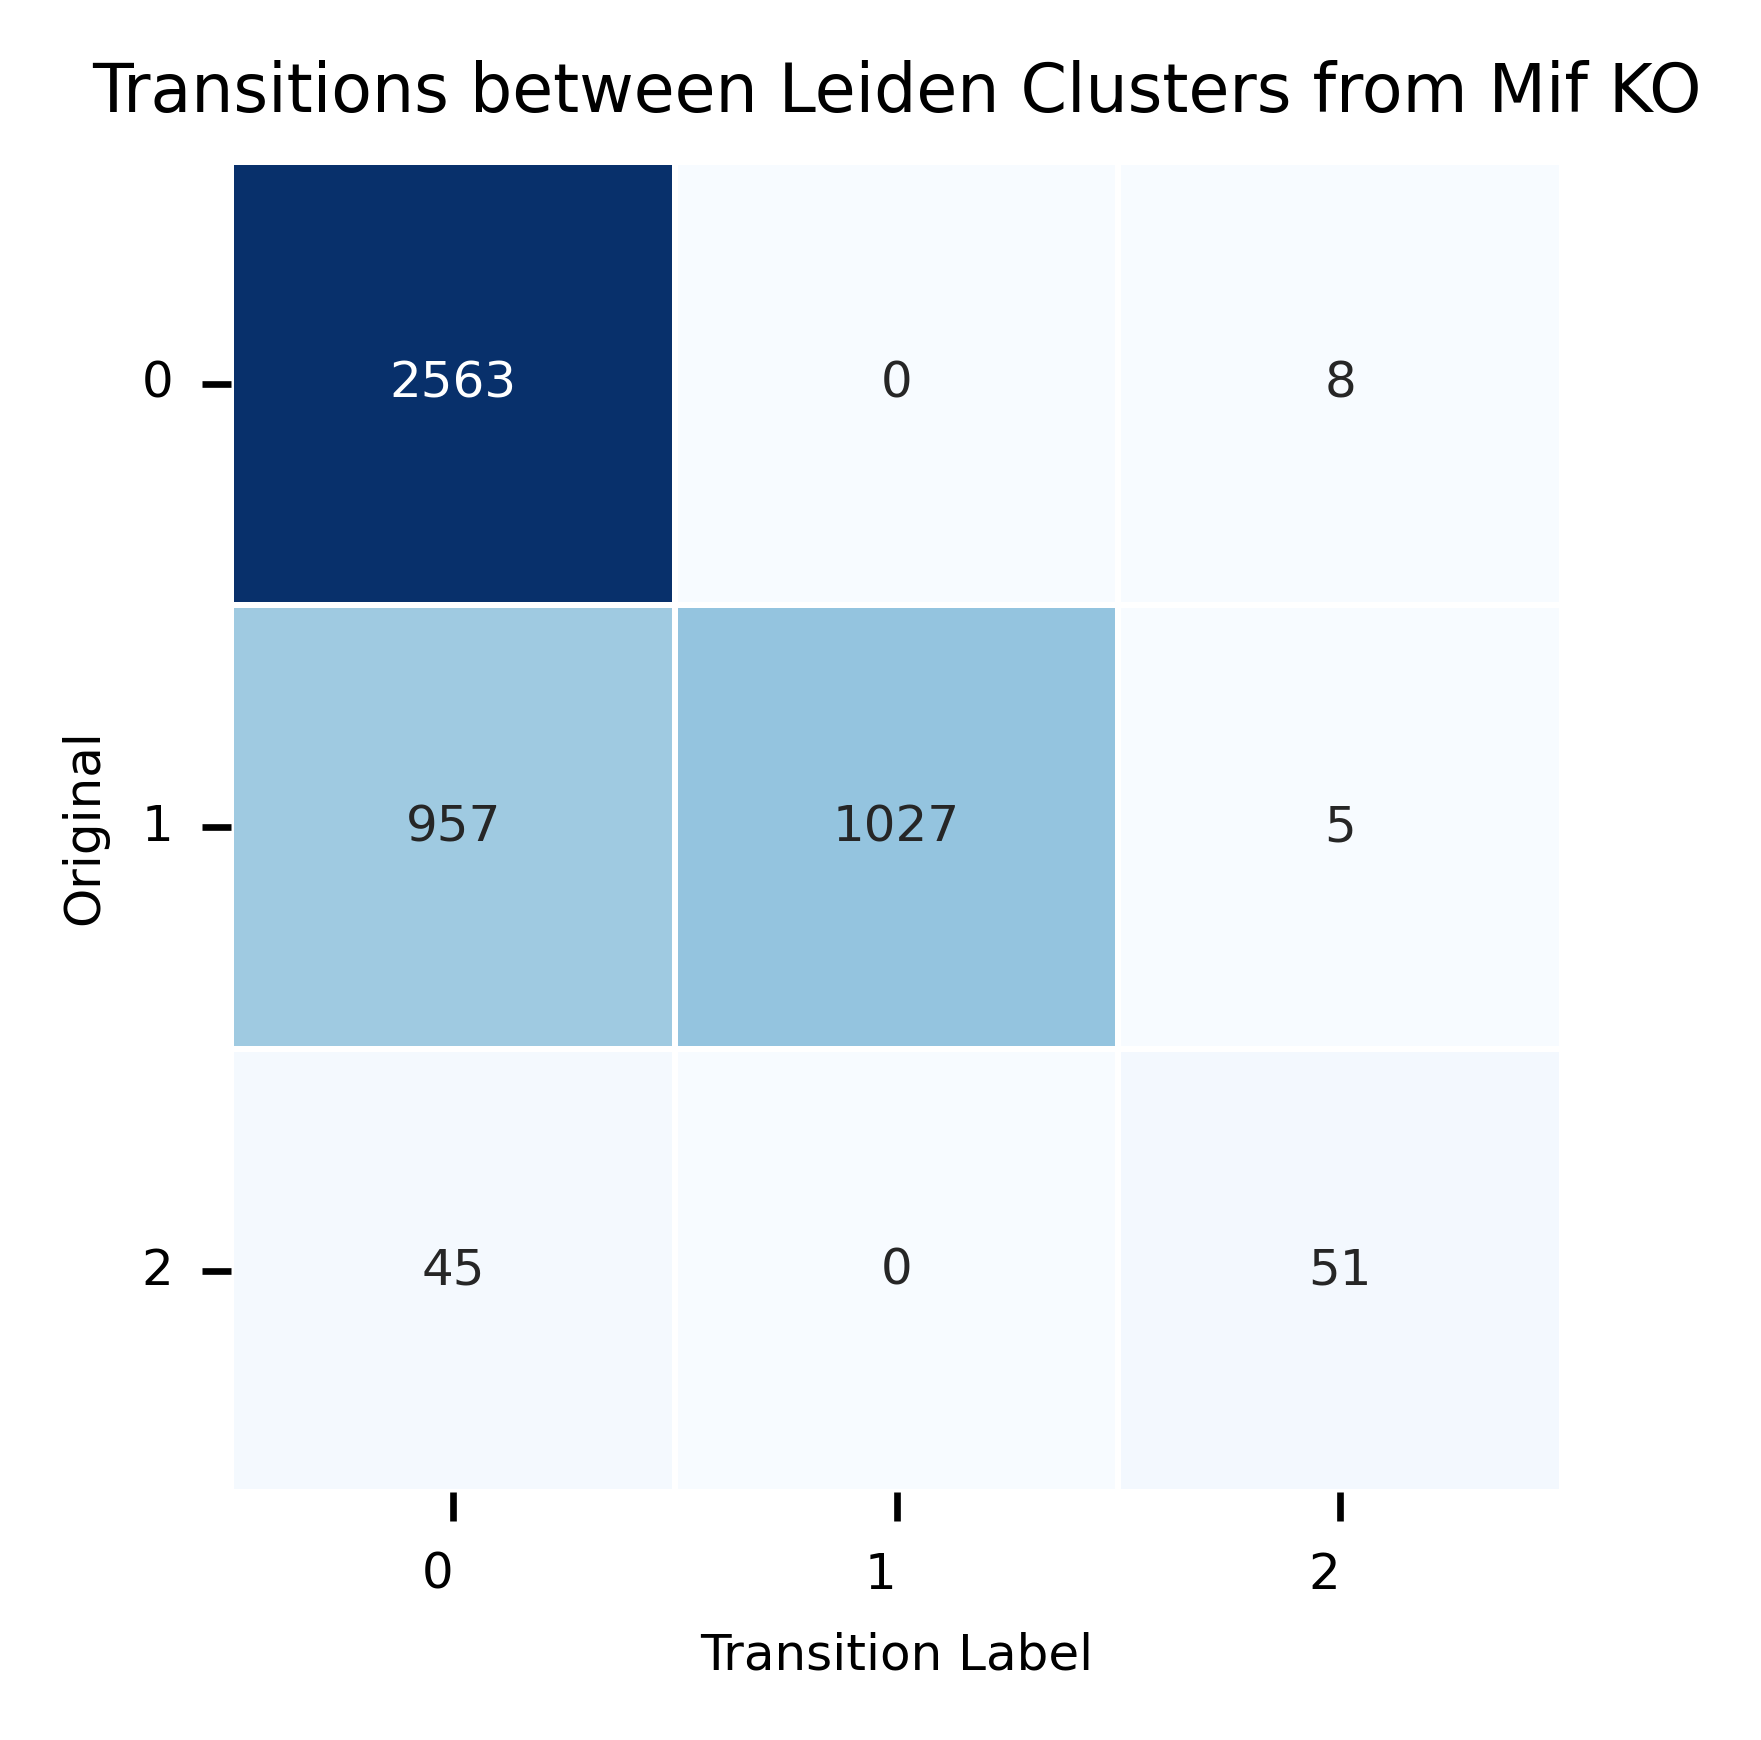

In [41]:
plt.figure(figsize=(3,3), dpi=300)

sns.heatmap(
    counts,
    annot=True,
    fmt='d',  # integer formatting
    cmap='Blues',  # nice clean color palette
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    square=True,
    annot_kws={"size": 6}
)

plt.title("Transitions between Leiden Clusters from Mif KO", fontsize=8)
plt.xlabel("Transition Label", fontsize=6)
plt.ylabel("Original", fontsize=6)
plt.xticks(rotation=0, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.savefig('figures/mouse_kidney_13_MifKO_transitions.svg', format='svg')
plt.tight_layout()
plt.show()

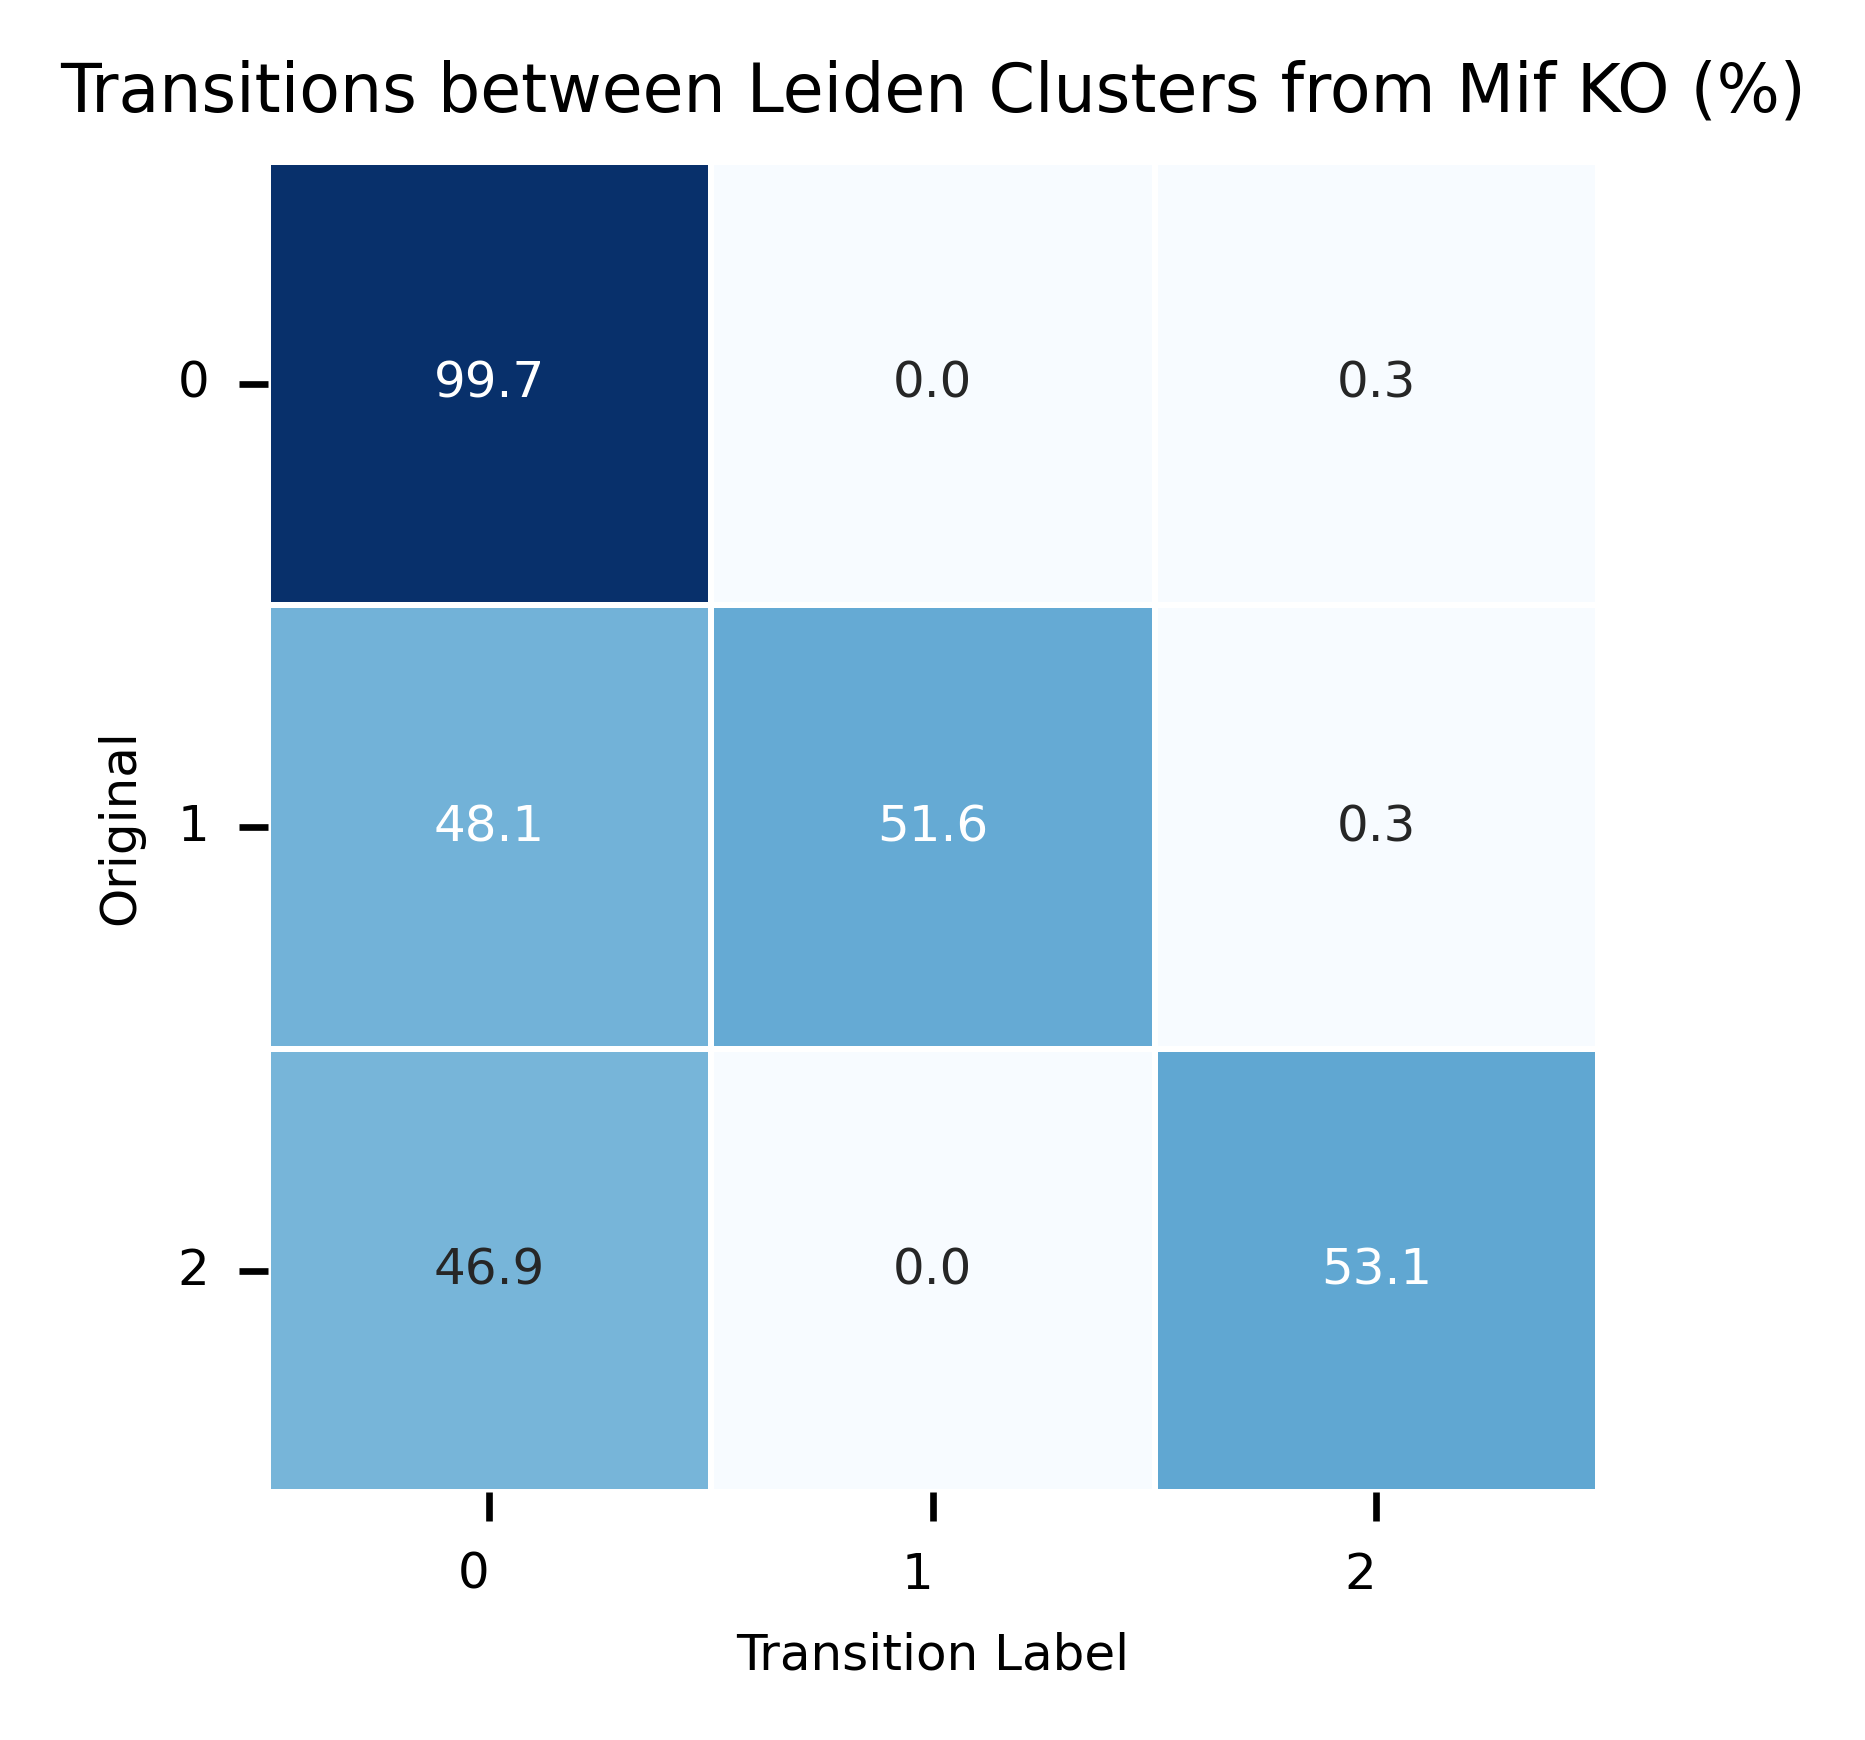

In [43]:
plt.figure(figsize=(3,3), dpi=300)

# Normalize counts by row (cluster)
counts_pct = counts.div(counts.sum(axis=1), axis=0) * 100

sns.heatmap(
    counts_pct,
    annot=True,
    fmt='.1f',  # float formatting with 1 decimal place
    cmap='Blues',  # nice clean color palette
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    square=True,
    annot_kws={"size": 6}
)

plt.title("Transitions between Leiden Clusters from Mif KO (%)", fontsize=8)
plt.xlabel("Transition Label", fontsize=6)
plt.ylabel("Original", fontsize=6)
plt.xticks(rotation=0, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.savefig('figures/mouse_kidney_13_MifKO_transitions_pct.svg', format='svg')
plt.tight_layout()
plt.show()

### Other random stuff

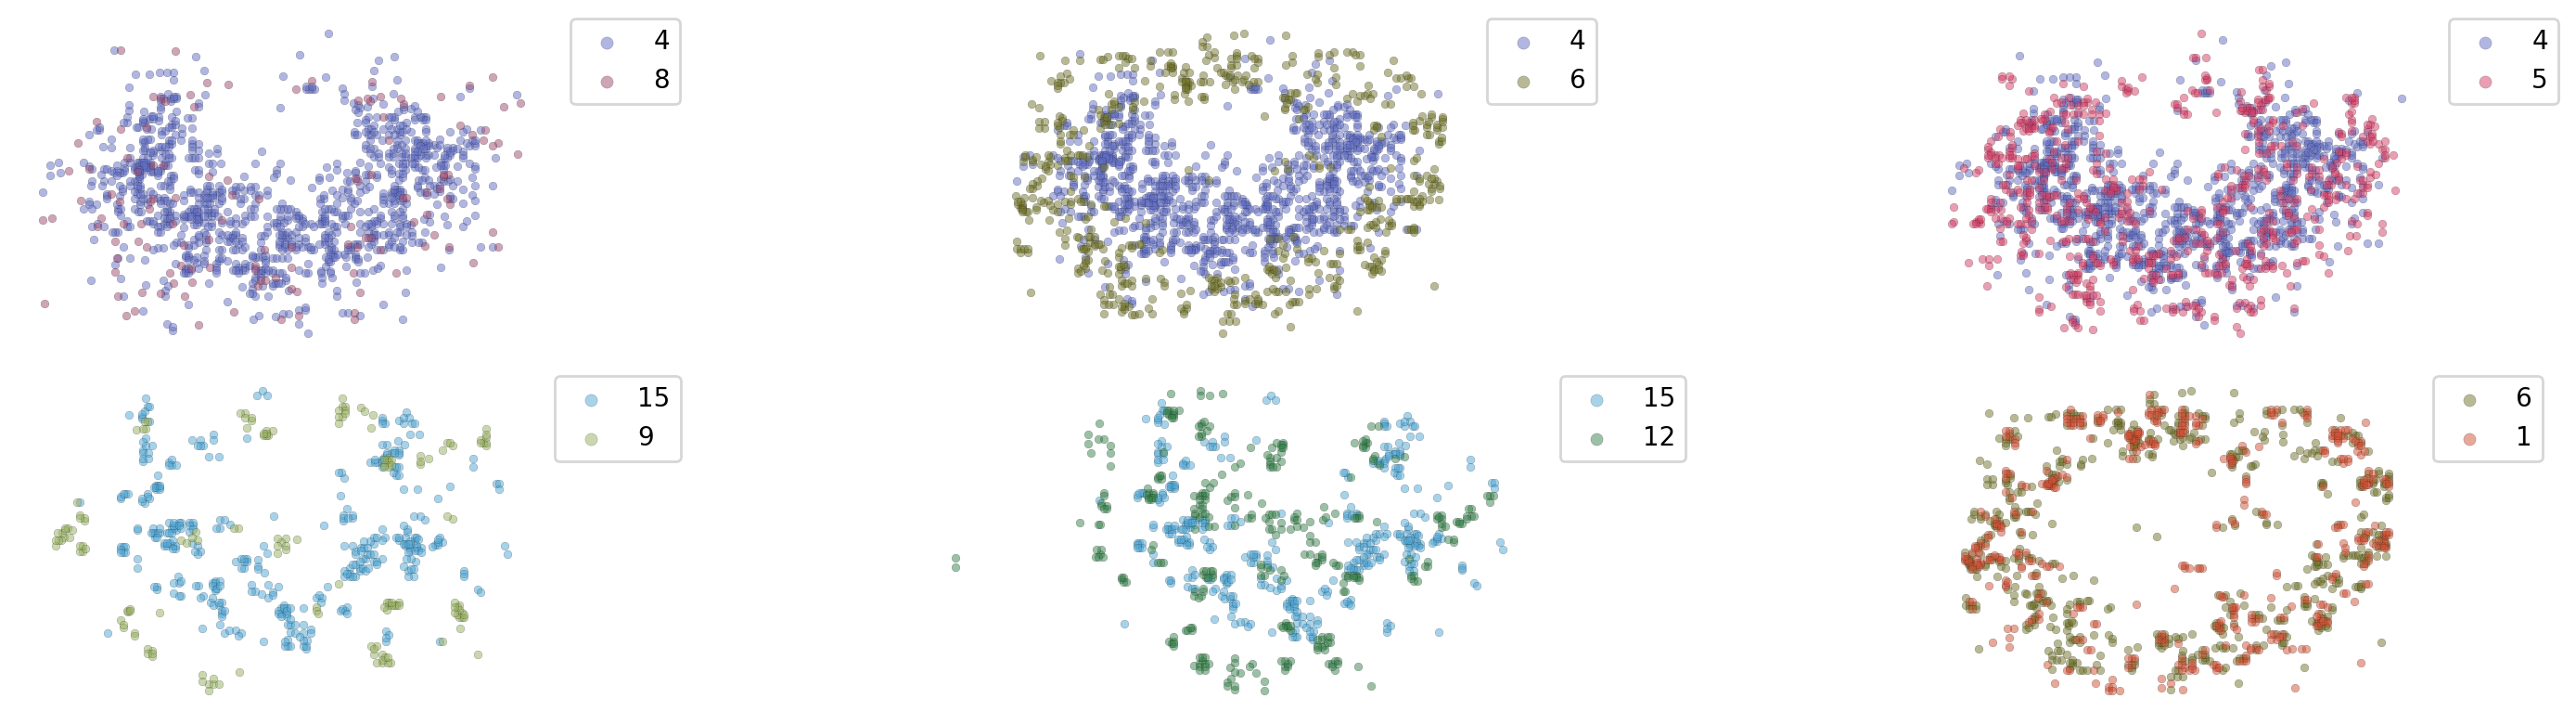

In [29]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 4))

def plot_spatial_cells(cts, ax):
    for ct in cts:
        mask = adata_.obs['banksy_cluster'] == ct
        ax.scatter(
            adata_.obsm['spatial'][mask, 0], adata_.obsm['spatial'][mask, 1],
            c=color_dict[ct], s=10, alpha=0.5, label=ct,
            edgecolor='black', linewidth=0.1
        )
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=1.5)
    ax.set_axis_off()
    ax.set_aspect('equal')   

plot_spatial_cells([4, 8], ax=ax1)
plot_spatial_cells([4, 6], ax=ax2)
plot_spatial_cells([4, 5], ax=ax3)
plot_spatial_cells([15, 9], ax=ax4)
plot_spatial_cells([15, 12], ax=ax5)
plot_spatial_cells([6, 1], ax=ax6)


plt.tight_layout()
plt.show()
